# Cluster Departments
The Aim is to evaluate characteristics of each department, including 'behaviors' - the volume of applications requests by employees in each department

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Exploration
### Applications Requested

In [2]:
# read applications file as pandas dataframe
apps = pd.read_csv("app_request_masked.csv")
print(apps.shape)
apps.head()

(31924, 4)


,masked_application,request_tracking_number,requestor,request_completion_date
0,Application-1,MH525695/004,59ec345a55d40fccd163e223676a6e81,3/1/2018 9:23
1,Application-2,MH527709/153,1f4bd6b3e3d503c6f26822fe5aacbeba,3/1/2018 15:23
2,Application-3,MH525269/154,569989a78b7a36df0c03e22c415f39b5,3/1/2018 6:54
3,Application-4,MH529257/001,d6c5c235d259183593c78248f0012f15,3/1/2018 12:30
4,Application-5,MH522731/037,bae19af6c89f43ade0b78de53be68d08,3/1/2018 0:58


Unique Apps  3095


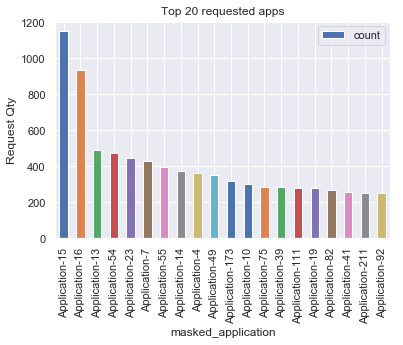

In [3]:
#How many applications?
print("Unique Apps ", len(apps.masked_application.unique()))

# Find out the top N applications requested
# group by applications and count applications, assign new column 'count', sort df in descending order
mapps = apps.groupby('masked_application').size().reset_index(name='count').sort_values('count', ascending=False )

# get the top twenty from the sorted df
top_twe = mapps.head(20)

#plot bar graph of applications
sns.set()
top_twe.plot(x='masked_application', y='count', kind='bar')
plt.title("Top 20 requested apps")
plt.ylabel('Request Qty')
plt.show()

count    3095.000000
mean       10.314701
std        41.938575
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1153.000000
Name: count, dtype: float64


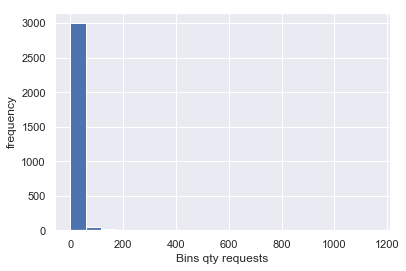

In [4]:
print(mapps['count'].describe())
plt.hist(mapps['count'], bins=20)
plt.ylabel('frequency')
plt.xlabel('Bins qty requests')
plt.show()

### Observations for Application Requests Volume
Applications have can have an extreme variation of demand; only 5 requests for up to the 75th percentile worth of requests made. The top 20 reporting a range between {~200, ~1200}.  

### Employees and Departments

In [5]:
# read applications file as pandas dataframe
emps = pd.read_csv("employee_masked_data.csv")
print(emps.shape)
emps.head()

(73310, 3)


,guid,region,masked_dept
0,13c545c35c0f4b712f0edc3e528f3fd1,EUROPE,Department-1
1,68f7c0dc2e3e2b2570144cdf72ac5ef4,PACIFIC,Department-2
2,a605bacfd0bc8eaf1c7a78837a4e94c3,PACIFIC,Department-3
3,957ae2723ad17dafcd7576ebcbee64bf,PACIFIC,Department-4
4,6d84dcbf449ba044d3984254a0b6a934,PACIFIC,Department-5


Unique Regions:  3 
 Unique Depts:  4619 
 Unique Employee:  73310


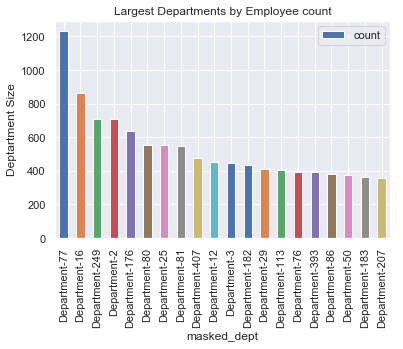

In [6]:
#How many Regions, Departments, and Employees (guid)?
print("Unique Regions: ", len(emps.region.unique()),"\n",
     "Unique Depts: ", len(emps.masked_dept.unique()),"\n",
      "Unique Employee: ",len(emps.guid.unique()))

# Find out the top N Department sizes
# group by departments and count size (employees per dept), assign new column 'count', sort df in descending order
emps_dept = emps.groupby('masked_dept').size().reset_index(name='count').sort_values('count', ascending=False )

# get the top twenty from the sorted df
top_twe = emps_dept.head(20)

#plot bar graph of applications
sns.set()
top_twe.plot(x='masked_dept', y='count', kind='bar')
plt.title("Largest Departments by Employee count")
plt.ylabel('Deptartment Size')
plt.show()

count    4619.000000
mean       15.871401
std        48.644038
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max      1232.000000
Name: count, dtype: float64


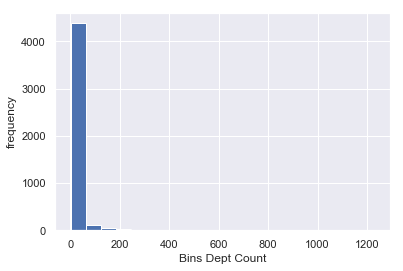

In [7]:
print(emps_dept['count'].describe())
plt.hist(emps_dept['count'], bins=20)
plt.ylabel('frequency')
plt.xlabel('Bins Dept Count')
plt.show()

### Observations for Department Sizes
Much like applications, Departmetns have great variation in employee size
### Data Exporloration Summary
Dealing with great variation / sparsity, and great magnitudes.  Will feature scale these values before clustering

## Prepare Datasets for Clustering

In [8]:
#join customers/orders on PK=FK
df = emps.join(apps.set_index('requestor'), on='guid')
print(df.shape)
df.head()

(88997, 6)


,guid,region,masked_dept,masked_application,request_tracking_number,request_completion_date
0,13c545c35c0f4b712f0edc3e528f3fd1,EUROPE,Department-1,NaN,NaN,NaN
1,68f7c0dc2e3e2b2570144cdf72ac5ef4,PACIFIC,Department-2,Application-245,MH908773/002,8/9/2018 0:38
1,68f7c0dc2e3e2b2570144cdf72ac5ef4,PACIFIC,Department-2,Application-1026,MH890222/001,7/31/2018 5:13
2,a605bacfd0bc8eaf1c7a78837a4e94c3,PACIFIC,Department-3,NaN,NaN,NaN
3,957ae2723ad17dafcd7576ebcbee64bf,PACIFIC,Department-4,NaN,NaN,NaN


In [9]:
# keep relevant columns, shuffle order
df = df[['region', 'masked_dept', 'guid',  'masked_application']]
print(df.shape)
df.head()

(88997, 4)


,region,masked_dept,guid,masked_application
0,EUROPE,Department-1,13c545c35c0f4b712f0edc3e528f3fd1,NaN
1,PACIFIC,Department-2,68f7c0dc2e3e2b2570144cdf72ac5ef4,Application-245
1,PACIFIC,Department-2,68f7c0dc2e3e2b2570144cdf72ac5ef4,Application-1026
2,PACIFIC,Department-3,a605bacfd0bc8eaf1c7a78837a4e94c3,NaN
3,PACIFIC,Department-4,957ae2723ad17dafcd7576ebcbee64bf,NaN


In [10]:
# get counts of regions, employees, and apps requested by Department
# since region is parameter included in model, only grouping by department 
df['region_cnt'] = df.groupby(['masked_dept']).region.transform('nunique')
df['app_cnt'] = df.groupby(['masked_dept']).masked_application.transform('count')
df['emp_cnt'] = df.groupby(['masked_dept']).guid.transform('nunique')
df.head()

,region,masked_dept,guid,masked_application,region_cnt,app_cnt,emp_cnt
0,EUROPE,Department-1,13c545c35c0f4b712f0edc3e528f3fd1,NaN,2,156,274
1,PACIFIC,Department-2,68f7c0dc2e3e2b2570144cdf72ac5ef4,Application-245,3,397,707
1,PACIFIC,Department-2,68f7c0dc2e3e2b2570144cdf72ac5ef4,Application-1026,3,397,707
2,PACIFIC,Department-3,a605bacfd0bc8eaf1c7a78837a4e94c3,NaN,3,511,446
3,PACIFIC,Department-4,957ae2723ad17dafcd7576ebcbee64bf,NaN,1,5,52


In [11]:
# Now that we've counted, drop duplicate dept entries
df = df.drop_duplicates(subset='masked_dept')
df = df[['masked_dept','region_cnt', 'emp_cnt', 'app_cnt']]

# sort top ten by app requests 
df.sort_values(by='app_cnt', ascending=False).head(10)

,masked_dept,region_cnt,emp_cnt,app_cnt
93,Department-81,3,547,565
13,Department-12,1,454,527
2,Department-3,3,446,511
133,Department-113,1,407,506
35,Department-32,3,342,443
1,Department-2,3,707,397
212,Department-176,3,637,391
224,Department-183,3,364,377
88,Department-76,3,395,362
28,Department-25,3,553,317


In [12]:
# sort top ten by employee count
df.sort_values(by='emp_cnt', ascending=False).head(10)

,masked_dept,region_cnt,emp_cnt,app_cnt
89,Department-77,2,1232,18
18,Department-16,1,863,17
313,Department-249,1,708,2
1,Department-2,3,707,397
212,Department-176,3,637,391
92,Department-80,3,556,0
28,Department-25,3,553,317
93,Department-81,3,547,565
587,Department-407,3,473,255
13,Department-12,1,454,527


### Observation
Visually seems that there might be slight correlation between department size and quantity of apps requested, but not entirely strong. We cannot make assumption that department size alone would be strong predictor for requested apps

In [13]:
# check for missing apps - should not be, all employee ids from apps_data are present in emps_data
print("missing? ",df['app_cnt'].isnull().any().any())
df['app_cnt'] = df['app_cnt'].fillna(0)
print("missing? ",df['app_cnt'].isnull().any().any())

missing?  False
missing?  False


In [14]:
# Get a summary of how many apps requested by departments for low-end requests volume
print("How many dept req apps = 0?: ", len(df[df['app_cnt'] == 0].index))
print("How many dept req apps = 1?: ", len(df[df['app_cnt'] == 1].index))
print("How many dept req apps = 2?: ", len(df[df['app_cnt'] == 2].index))
print("How many dept req apps > 2?: ", len(df[df['app_cnt'] > 2].index))

How many dept req apps = 0?:  2312
How many dept req apps = 1?:  708
How many dept req apps = 2?:  323
How many dept req apps > 2?:  1276


Many departments that would be considered a low-volume in app requests
### Feature Scale Values

In [15]:
# from sklearn.preprocessing import StandardScaler
# choosing MaxAbs since its intended to help keep sparsity - unlike StandardScaler
# https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.preprocessing import MaxAbsScaler

# Create the Scaler 
scaler = MaxAbsScaler()

# create a copy to rejoin original values after scaling
df1 = df.copy()
df1.head()

,masked_dept,region_cnt,emp_cnt,app_cnt
0,Department-1,2,274,156
1,Department-2,3,707,397
2,Department-3,3,446,511
3,Department-4,1,52,5
4,Department-5,1,2,0


In [16]:
# Scale the features to the copied df
df1[['region_cnt', 'emp_cnt', 'app_cnt']] = scaler.fit_transform(df1[['region_cnt', 'emp_cnt', 'app_cnt']])

# Rename these Scaled features to 's_[feature]''
df1.rename(columns={'region_cnt': 's_region_cnt', 'emp_cnt': 's_emp_cnt', 'app_cnt': 's_app_cnt'}, inplace=True)

# join dfs back together, to keep scaled and original values in same df
df = df1.join(df.set_index('masked_dept'), on='masked_dept')
df.head()

,masked_dept,s_region_cnt,s_emp_cnt,s_app_cnt,region_cnt,emp_cnt,app_cnt
0,Department-1,0.666667,0.222403,0.276106,2,274,156
1,Department-2,1.000000,0.573864,0.702655,3,707,397
2,Department-3,1.000000,0.362013,0.904425,3,446,511
3,Department-4,0.333333,0.042208,0.008850,1,52,5
4,Department-5,0.333333,0.001623,0.000000,1,2,0


Looks like scaling did it right - where region = 1, => .333; r=2, => .667; r=3, => 1.00  

## Estimate Number of Clusters to Model

In [17]:
from sklearn import metrics
from sklearn.cluster import KMeans

# Our 3 features by which to cluster department's 'characteristics'
X = df[['s_region_cnt','s_emp_cnt','s_app_cnt']].values

In [18]:
WCSS = []

#select min and max clusters (max excluded from range)
kmin = 1
kmax = 11
for i in range(kmin, kmax):
    # Instantiate the model
    #number of clusters
    # init = ‘k-means++’ to help convergence 
    # max_iter number of iterations to find kmeans, default is 300
    # n_init = Number of time the k-means algorithm will be run with different centroid seeds, default = 10
    kmeans = KMeans(n_clusters = i, 
                    init = 'k-means++', 
                    max_iter = 400, 
                    n_init = 15, 
                    random_state = 42)
    # Fit model to data, get labels (error), append to list
    kmeans.fit(X)
    labels = kmeans.labels_
    WCSS.append(kmeans.inertia_)


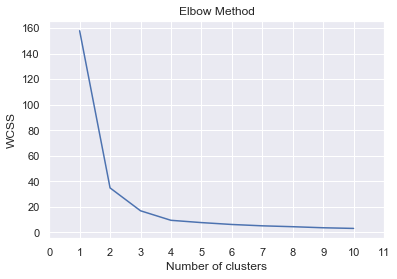

In [19]:
plt.plot(range(kmin, kmax), WCSS)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(kmin-1, kmax+1, 1.0))
plt.show()

We have a hard break at 2 clusters, however 3 looks like an ok break, beyond 4 is really pushing things... considering that error is based off of scaled values in range {0,1}, we might be able to argue for 3 and 4

## KMeans 3-clusters

In [20]:
# Instantiate 3-cluster model
km3 = KMeans(n_clusters=3, 
                init = 'k-means++', 
                max_iter = 400, 
                n_init = 15, 
                random_state = 42)

# fit to the df dataset
km3.fit(df[['s_region_cnt','s_emp_cnt','s_app_cnt']])

# 'predict' the centroids
y_pred = km3.fit_predict(df[['s_region_cnt','s_emp_cnt','s_app_cnt']])

# evaluate centroids 
centroids = km3.cluster_centers_
km_map = pd.DataFrame(centroids)
km_map

,0,1,2
0,1.000000,0.073867,0.109142
1,0.333333,0.007561,0.004554
2,0.666667,0.028207,0.027556


In [21]:
# array of indexes corresponding to classes around centroids, in the order of the dataset
clusters = km3.labels_
print(len(clusters))

# create km3 dataframe with all features = normal, scaled, and cluster assignments
df_km3 = df.copy()
df_km3['cluster'] = pd.Series(clusters, index=df_km3.index)
df_km3.head()

4619


,masked_dept,s_region_cnt,s_emp_cnt,s_app_cnt,region_cnt,emp_cnt,app_cnt,cluster
0,Department-1,0.666667,0.222403,0.276106,2,274,156,2
1,Department-2,1.000000,0.573864,0.702655,3,707,397,0
2,Department-3,1.000000,0.362013,0.904425,3,446,511,0
3,Department-4,0.333333,0.042208,0.008850,1,52,5,1
4,Department-5,0.333333,0.001623,0.000000,1,2,0,1


In [22]:
# write to csv file; to be used in Applications clustering 
# intuition: Departments are now categorized - we have an idea of their behavior
df_km3[['masked_dept','region_cnt', 'emp_cnt', 'app_cnt', 'cluster']].to_csv('departments_km3.csv', index=False)

### Visualize and Inspect
We clustered on the scaled values, but scaled values doesn't mean much when trying to understand the departments and how to categorize them.  Let's visualize using the actual values for visualization and interpetation

In [23]:
df_km3 = df_km3[['masked_dept','region_cnt', 'emp_cnt', 'app_cnt', 'cluster']]

In [24]:
## Get clusters in separte dfs
# Cluster 0
df_c0 = df_km3.loc[df_km3['cluster'] == 0].copy()
print(len(df_c0.index))

# Cluster  1
df_c1 = df_km3.loc[df_km3['cluster'] == 1].copy()
print(len(df_c1.index))

# Cluster 2
df_c2 = df_km3.loc[df_km3['cluster'] == 2].copy()
print(len(df_c2.index))

# add them all to a list
cluster_list = [df_c0, df_c1, df_c2]

263
4010
346


In [25]:
from mpl_toolkits.mplot3d import Axes3D

<Figure size 640x480 with 0 Axes>

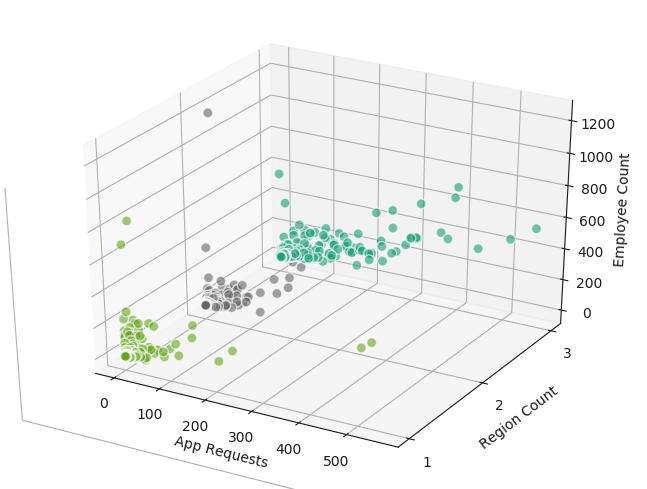

In [26]:
sns.reset_orig()
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
plt.clf()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# assign features to axis
xs = df_km3['app_cnt']
ys = df_km3['region_cnt']
zs = df_km3['emp_cnt']
cs = df_km3['cluster']

# assign colors to clusters
cmap = plt.cm.get_cmap('Dark2', df_km3.cluster.nunique())
ax.scatter(xs, ys, zs,
           cmap=cmap, 
           c=cs,
           s=50, 
           alpha=0.6, edgecolors='w')

ax.set_xlabel('App Requests')
ax.set_ylabel('Region Count')
ax.set_zlabel('Employee Count')
plt.xticks(np.arange(0, 600, 100))
plt.yticks(np.arange(0, 4, 1))
plt.show()

Looks like they clustered OK, there are some outliers that look out of place

In [27]:
# Generate a descriptive report of cluster assignments
for i in range(len(cluster_list)):
    print("Cluster: ",i,"\n",cluster_list[i][['region_cnt', 'emp_cnt', 'app_cnt']].describe(),"\n")

Cluster:  0 
        region_cnt     emp_cnt     app_cnt
count       263.0  263.000000  263.000000
mean          3.0   91.003802   61.665399
std           0.0  114.448111   94.505070
min           3.0    5.000000    0.000000
25%           3.0   23.000000    8.000000
50%           3.0   46.000000   20.000000
75%           3.0  102.000000   67.500000
max           3.0  707.000000  565.000000 

Cluster:  1 
        region_cnt      emp_cnt      app_cnt
count      4010.0  4010.000000  4010.000000
mean          1.0     9.314713     2.573067
std           0.0    28.615656    14.286725
min           1.0     1.000000     0.000000
25%           1.0     1.000000     0.000000
50%           1.0     2.000000     0.000000
75%           1.0     8.000000     2.000000
max           1.0   863.000000   527.000000 

Cluster:  2 
        region_cnt      emp_cnt     app_cnt
count       346.0   346.000000  346.000000
mean          2.0    34.751445   15.569364
std           0.0    83.967120   30.241101
min     

The descriptive statistics add better support. The quantity of regions a department might belong to is a strong feature, there is no deviation by groups.  We might want to look at this from a different perspective. I could try out breaking things down by department and region, creating "department-region" compound feature.

## KMeans 4-clusters
Follow same steps, but with 4 clusters

In [28]:
# Instantiate 4-cluster model
km4 = KMeans(n_clusters=4, 
                init = 'k-means++', 
                max_iter = 400, 
                n_init = 15, 
                random_state = 42)

# fit to the df dataset
km4.fit(df[['s_region_cnt','s_emp_cnt','s_app_cnt']])

# 'predict' the centroids
y_pred = km4.fit_predict(df[['s_region_cnt','s_emp_cnt','s_app_cnt']])

# evaluate centroids 
centroids = km4.cluster_centers_
km_map = pd.DataFrame(centroids)
km_map

,0,1,2
0,0.333333,0.007390,0.004100
1,1.000000,0.051084,0.059436
2,0.666667,0.022477,0.023761
3,0.916667,0.285196,0.501573


In [29]:
# array of indexes corresponding to classes around centroids, in the order of the dataset
clusters = km4.labels_
print(len(clusters))

# create km3 dataframe with all features = normal, scaled, and cluster assignments
df_km4 = df.copy()
df_km4['cluster'] = pd.Series(clusters, index=df_km4.index)
df_km4.head()

4619


,masked_dept,s_region_cnt,s_emp_cnt,s_app_cnt,region_cnt,emp_cnt,app_cnt,cluster
0,Department-1,0.666667,0.222403,0.276106,2,274,156,2
1,Department-2,1.000000,0.573864,0.702655,3,707,397,3
2,Department-3,1.000000,0.362013,0.904425,3,446,511,3
3,Department-4,0.333333,0.042208,0.008850,1,52,5,0
4,Department-5,0.333333,0.001623,0.000000,1,2,0,0


In [30]:
# write to csv file; to be used in Applications clustering 
# intuition: Departments are now categorized - we have an idea of their behavior
df_km4[['masked_dept','region_cnt', 'emp_cnt', 'app_cnt', 'cluster']].to_csv('departments_km4.csv', index=False)

### Visualize and Inspect
visualize using the actual values for visualization and interpetation

In [31]:
df_km4 = df_km4[['masked_dept','region_cnt', 'emp_cnt', 'app_cnt', 'cluster']]

In [32]:
## Get clusters in separte dfs
# Cluster 0
df_c0 = df_km4.loc[df_km4['cluster'] == 0].copy()
print(len(df_c0.index))

# Cluster  1
df_c1 = df_km4.loc[df_km4['cluster'] == 1].copy()
print(len(df_c1.index))

# Cluster 2
df_c2 = df_km4.loc[df_km4['cluster'] == 2].copy()
print(len(df_c2.index))

# Cluster 3
df_c3 = df_km4.loc[df_km4['cluster'] == 3].copy()
print(len(df_c3.index))

# add them all to a list
cluster_list = [df_c0, df_c1, df_c2, df_c3]

4008
234
341
36


This one already looks like we converged to distinguish discrepancies with the sparse data.  The large cluster should be a low volume cluster, whereas the smaller cluster should be high volume

<Figure size 640x480 with 0 Axes>

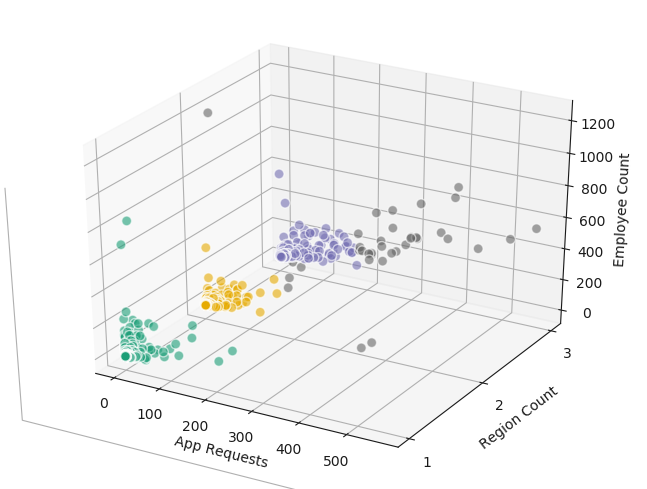

In [33]:
# Visualizing 3-D numeric data with Scatter Plots
# length, breadth and depth
plt.clf()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# assign features to axis
xs = df_km4['app_cnt']
ys = df_km4['region_cnt']
zs = df_km4['emp_cnt']
cs = df_km4['cluster']

# assign colors to clusters
cmap = plt.cm.get_cmap('Dark2', df_km4.cluster.nunique())
ax.scatter(xs, ys, zs,
           cmap=cmap, 
           c=cs,
           s=50, 
           alpha=0.6, edgecolors='w')

ax.set_xlabel('App Requests')
ax.set_ylabel('Region Count')
ax.set_zlabel('Employee Count')
plt.xticks(np.arange(0, 600, 100))
plt.yticks(np.arange(0, 4, 1))
plt.show()

Yep, that quadrant of medium sized employee counts, but medium-to-high app requests converged better

In [34]:
# Generate a descriptive report of cluster assignments
for i in range(len(cluster_list)):
    print("Cluster: ",i,"\n",cluster_list[i][['region_cnt', 'emp_cnt', 'app_cnt']].describe(),"\n")

Cluster:  0 
        region_cnt      emp_cnt      app_cnt
count      4008.0  4008.000000  4008.000000
mean          1.0     9.104541     2.316617
std           0.0    27.025934     8.500697
min           1.0     1.000000     0.000000
25%           1.0     1.000000     0.000000
50%           1.0     2.000000     0.000000
75%           1.0     8.000000     2.000000
max           1.0   863.000000   236.000000 

Cluster:  1 
        region_cnt     emp_cnt     app_cnt
count       234.0  234.000000  234.000000
mean          3.0   62.935897   33.581197
std           0.0   67.808998   40.861168
min           3.0    5.000000    0.000000
25%           3.0   21.250000    6.000000
50%           3.0   40.000000   15.000000
75%           3.0   75.000000   41.750000
max           3.0  556.000000  176.000000 

Cluster:  2 
        region_cnt     emp_cnt    app_cnt
count       341.0  341.000000  341.00000
mean          2.0   27.692082   13.42522
std           0.0   41.906221   23.05169
min           2.

4 clusters seems quite a bit more compelling for converging to an optimum.  Based on which cluster each department belongs, we might want to attend to them differently.  We know that there are those 36 departments that will constantly need attention, but there are about 4,000 that need minimal attention, if any.  This coincides with the pareto principle, where 20% of departments create 80% of the demand, except here our numbers might be fewer than 20%.  
These aren't real deterministic factors on changing policy or procedures, but this does give us an insight into some behaviors and might aid in contributing to further analyses.

In [35]:
df_km4.head()

,masked_dept,region_cnt,emp_cnt,app_cnt,cluster
0,Department-1,2,274,156,2
1,Department-2,3,707,397,3
2,Department-3,3,446,511,3
3,Department-4,1,52,5,0
4,Department-5,1,2,0,0
